**Resnet_50 model**

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s] 


Epoch [1/10], Loss: 2.3430
Epoch [2/10], Loss: 1.2736
Epoch [3/10], Loss: 0.9348
Epoch [4/10], Loss: 0.8100
Epoch [5/10], Loss: 0.6710
Epoch [6/10], Loss: 0.5952
Epoch [7/10], Loss: 0.5032
Epoch [8/10], Loss: 0.4640
Epoch [9/10], Loss: 0.4034
Epoch [10/10], Loss: 0.3647
              precision    recall  f1-score   support

       TV_22       1.00      0.75      0.86        20
       TV_30       0.92      0.71      0.80        17
       TV_10       0.93      0.70      0.80        20
       TV_04       1.00      0.75      0.86         4
       TV_17       1.00      0.60      0.75        20
       TV_26       0.62      0.65      0.63        20
       TV_18       0.95      1.00      0.98        20
       TV_27       0.88      0.75      0.81        20
       TV_29       0.84      0.80      0.82        20
       TV_13       0.90      0.95      0.93        20
       TV_03       0.94      0.85      0.89        20
       TV_16       0.70      0.70      0.70        20
       TV_08       0.77   

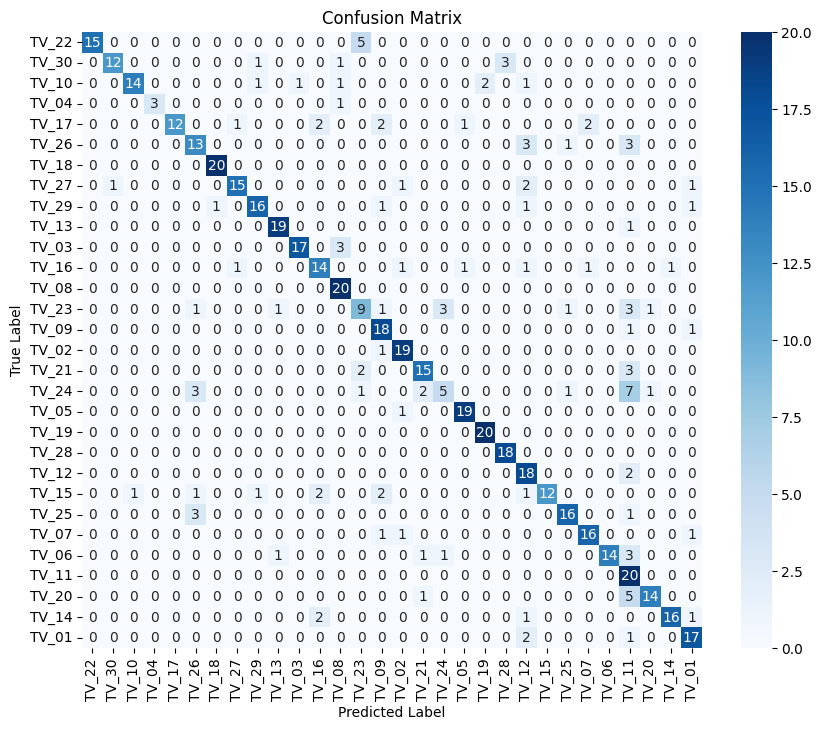

In [10]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'

# Create lists to hold file paths and labels
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load ResNet50 model
model = models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / dataset_sizes['train']
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [11]:
import torch
import numpy as np

# Assuming you already have your model, dataloader, and criterion defined
model.eval()  # Set the model to evaluation mode

# Initialize variables to store correct predictions and total predictions
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)  # Move inputs to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device
        
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        
        total += labels.size(0)  # Increment total count
        correct += (predicted == labels).sum().item()  # Increment correct predictions

# Calculate overall accuracy
overall_accuracy = correct / total * 100  # Convert to percentage

print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


Overall Accuracy on Validation Set: 78.37%


**EfficientNet model**


Epoch [1/4], Loss: 1.7865
Epoch [2/4], Loss: 0.8376
Epoch [3/4], Loss: 0.5617
Epoch [4/4], Loss: 0.4149
              precision    recall  f1-score   support

       TV_22       0.94      0.85      0.89        20
       TV_30       0.89      1.00      0.94        17
       TV_10       1.00      0.80      0.89        20
       TV_04       0.50      0.50      0.50         4
       TV_17       1.00      0.80      0.89        20
       TV_26       0.89      0.40      0.55        20
       TV_18       1.00      1.00      1.00        20
       TV_27       0.73      0.80      0.76        20
       TV_29       0.85      0.85      0.85        20
       TV_13       1.00      0.90      0.95        20
       TV_03       0.94      0.80      0.86        20
       TV_16       0.75      0.90      0.82        20
       TV_08       0.94      0.85      0.89        20
       TV_23       0.68      0.65      0.67        20
       TV_09       0.75      0.90      0.82        20
       TV_02       0.90      0.

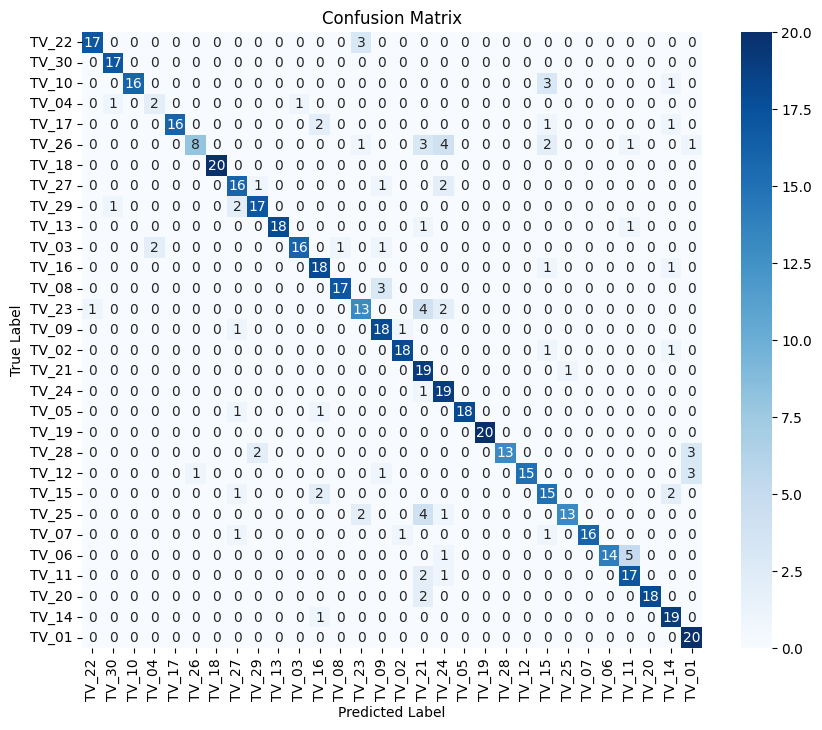

Overall Accuracy on Validation Set: 85.81%


In [4]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model
model = models.efficientnet_b3(weights='DEFAULT')  # Using EfficientNet-B3
num_ftrs = model.classifier[1].in_features  # Access the Linear layer's in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 4  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / dataset_sizes['train']
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


Epoch [1/10], Loss: 2.3232
Validation Loss: 1.6149
Epoch [2/10], Loss: 1.2000
Validation Loss: 1.2103
Epoch [3/10], Loss: 0.7933
Validation Loss: 0.8554
Epoch [4/10], Loss: 0.6634
Validation Loss: 0.6811
Epoch [5/10], Loss: 0.5461
Validation Loss: 0.7118
Epoch [6/10], Loss: 0.4693
Validation Loss: 0.7066
Epoch [7/10], Loss: 0.3470
Validation Loss: 0.5617
Epoch [8/10], Loss: 0.3564
Validation Loss: 1.1118
Epoch [9/10], Loss: 0.3562
Validation Loss: 0.5404
Epoch [10/10], Loss: 0.2813
Validation Loss: 0.5249
              precision    recall  f1-score   support

       TV_22       0.71      1.00      0.83        20
       TV_30       0.94      0.88      0.91        17
       TV_10       0.90      0.90      0.90        20
       TV_04       1.00      0.25      0.40         4
       TV_17       0.86      0.95      0.90        20
       TV_26       0.64      0.80      0.71        20
       TV_18       1.00      0.95      0.97        20
       TV_27       0.71      0.60      0.65        20
  

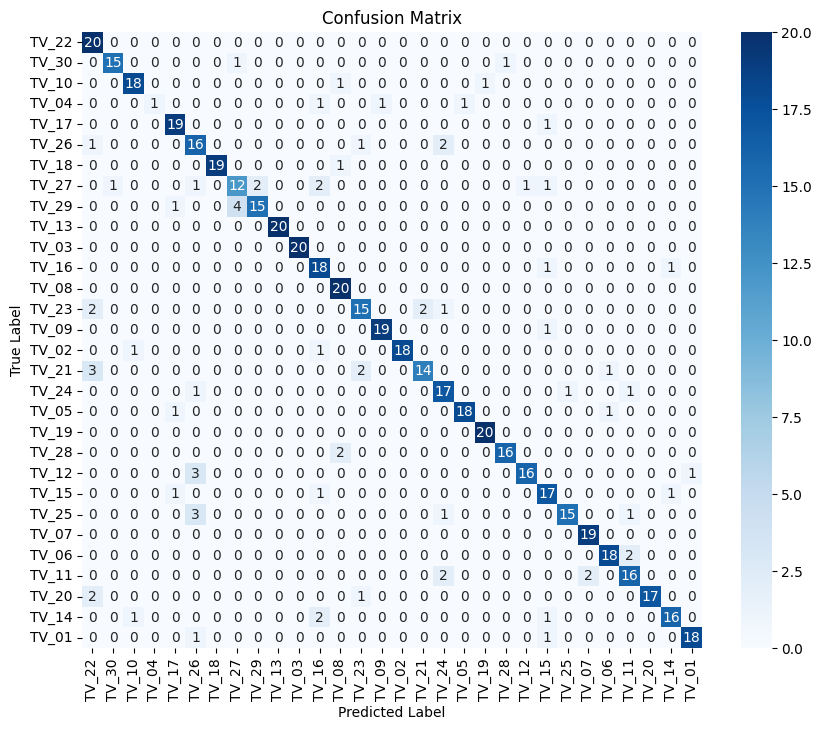

Overall Accuracy on Validation Set: 83.22%


In [7]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model with Dropout
model = models.efficientnet_b3(weights='DEFAULT')
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Add Dropout
    nn.Linear(num_ftrs, len(class_names))
)
model = model.to(device)

# Set criterion and optimizer with weight decay for L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay

# Set up the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
counter = 0

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / dataset_sizes['train']
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= dataset_sizes['val']
    print(f'Validation Loss: {val_loss:.4f}')

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


Epoch 1/4: 100%|██████████| 72/72 [02:16<00:00,  1.89s/batch, loss=1.52] 


Epoch [1/4], Train Loss: 1.8329, Val Loss: 1.5287, Time: 171.93s


Epoch 2/4: 100%|██████████| 72/72 [02:17<00:00,  1.91s/batch, loss=0.399]


Epoch [2/4], Train Loss: 0.8489, Val Loss: 0.8030, Time: 172.71s


Epoch 3/4: 100%|██████████| 72/72 [02:18<00:00,  1.92s/batch, loss=0.331]


Epoch [3/4], Train Loss: 0.5491, Val Loss: 0.6664, Time: 174.12s


Epoch 4/4: 100%|██████████| 72/72 [02:16<00:00,  1.90s/batch, loss=0.16]  


Epoch [4/4], Train Loss: 0.4094, Val Loss: 0.3758, Time: 172.11s
              precision    recall  f1-score   support

       TV_22       0.95      0.95      0.95        20
       TV_30       0.76      0.94      0.84        17
       TV_10       0.95      0.95      0.95        20
       TV_04       1.00      0.75      0.86         4
       TV_17       0.94      0.80      0.86        20
       TV_26       0.89      0.80      0.84        20
       TV_18       1.00      0.95      0.97        20
       TV_27       0.80      0.80      0.80        20
       TV_29       0.82      0.70      0.76        20
       TV_13       1.00      1.00      1.00        20
       TV_03       1.00      0.90      0.95        20
       TV_16       0.74      0.85      0.79        20
       TV_08       0.83      1.00      0.91        20
       TV_23       0.81      0.85      0.83        20
       TV_09       0.83      0.95      0.88        20
       TV_02       0.83      0.95      0.88        20
       TV_21    

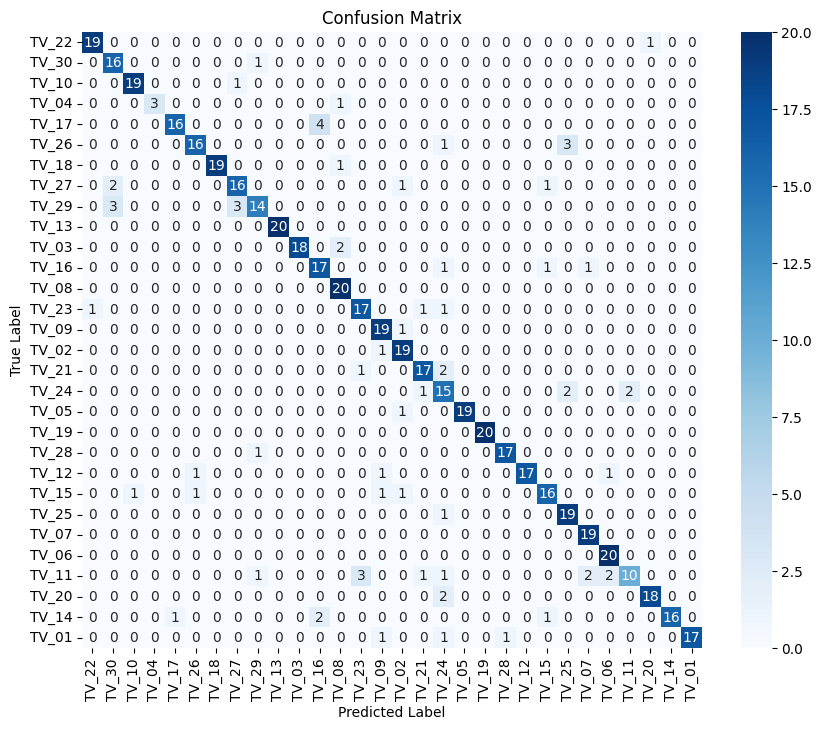

Overall Accuracy on Validation Set: 87.37%


In [8]:
import os
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm  # For progress bar

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model
model = models.efficientnet_b3(weights='DEFAULT')  # Using EfficientNet-B3
num_ftrs = model.classifier[1].in_features  # Access the Linear layer's in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation loss and time tracking
num_epochs = 4  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    
    # Training phase
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_bar.set_postfix(loss=loss.item())  # Update the progress bar with current loss

    epoch_loss = running_loss / dataset_sizes['train']
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / dataset_sizes['val']
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {elapsed_time:.2f}s')

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


Efficientnet b3 on full dataset tested trained on 80

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 158MB/s] 
Epoch 1/4: 100%|██████████| 72/72 [02:18<00:00,  1.92s/batch, loss=0.431]


Epoch [1/4], Train Loss: 1.8340, Val Loss: 0.9783, Time: 173.73s


Epoch 2/4: 100%|██████████| 72/72 [02:15<00:00,  1.88s/batch, loss=1.2]  


Epoch [2/4], Train Loss: 0.8396, Val Loss: 0.8710, Time: 169.22s


Epoch 3/4: 100%|██████████| 72/72 [02:12<00:00,  1.84s/batch, loss=1.36] 


Epoch [3/4], Train Loss: 0.6192, Val Loss: 0.6066, Time: 167.30s


Epoch 4/4: 100%|██████████| 72/72 [02:12<00:00,  1.83s/batch, loss=0.243]


Epoch [4/4], Train Loss: 0.4086, Val Loss: 0.3272, Time: 167.13s
              precision    recall  f1-score   support

       TV_22       0.96      0.99      0.98        99
       TV_30       0.94      0.98      0.96        85
       TV_10       0.93      0.99      0.96        99
       TV_04       1.00      0.94      0.97        18
       TV_17       0.76      1.00      0.87       100
       TV_26       0.91      0.83      0.87       100
       TV_18       1.00      1.00      1.00        98
       TV_27       0.97      0.77      0.86        98
       TV_29       0.80      0.98      0.88       100
       TV_13       1.00      0.99      0.99        99
       TV_03       0.82      1.00      0.90       100
       TV_16       0.83      0.83      0.83        98
       TV_08       0.98      0.93      0.95        96
       TV_23       0.80      0.84      0.82        98
       TV_09       1.00      0.94      0.97        99
       TV_02       0.97      0.96      0.96        98
       TV_21    

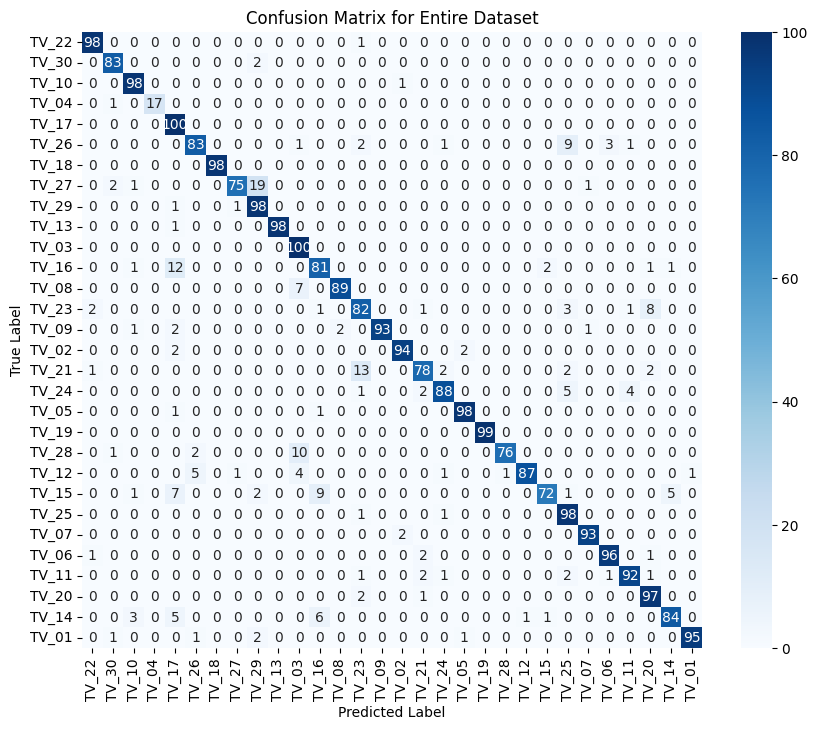

Overall Accuracy on Entire Dataset: 92.21%


In [1]:
import os
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm  # For progress bar

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model
model = models.efficientnet_b3(weights='DEFAULT')  # Using EfficientNet-B3
num_ftrs = model.classifier[1].in_features  # Access the Linear layer's in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation loss and time tracking
num_epochs = 4  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    
    # Training phase
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_bar.set_postfix(loss=loss.item())  # Update the progress bar with current loss

    epoch_loss = running_loss / dataset_sizes['train']
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / dataset_sizes['val']
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {elapsed_time:.2f}s')

# Combine training and validation images and labels for final evaluation
all_images_combined = train_images + val_images
all_labels_combined = train_labels + val_labels

# Create a new dataset and dataloader for the entire dataset
combined_dataset = CustomDataset(all_images_combined, all_labels_combined, transform=data_transforms)
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate the model on the entire dataset
model.eval()
all_preds = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in combined_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Classification report for the entire dataset
print(classification_report(all_true_labels, all_preds, target_names=class_names))

# Confusion matrix for the entire dataset
conf_matrix = confusion_matrix(all_true_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Entire Dataset')
plt.show()

# Calculate overall accuracy on the entire dataset
correct = np.sum(np.array(all_preds) == np.array(all_true_labels))
total = len(all_true_labels)
overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Entire Dataset: {overall_accuracy:.2f}%')


In [3]:
# Save the model weights
torch.save(model.state_dict(), 'efficientnet_b3_weights.pth')
print("Model weights saved as 'efficientnet_b3_weights.pth'.")

# Save the entire model (architecture + weights)
torch.save(model, 'efficientnet_b3_full_model.pth')
print("Entire model saved as 'efficientnet_b3_full_model.pth'.")


Model weights saved as 'efficientnet_b3_weights.pth'.
Entire model saved as 'efficientnet_b3_full_model.pth'.


Swin Transformer

Epoch 1/4: 100%|██████████| 72/72 [02:18<00:00,  1.92s/batch, loss=1.54]


Epoch [1/4], Train Loss: 2.4043, Val Loss: 1.0849, Time: 172.86s


Epoch 2/4: 100%|██████████| 72/72 [02:18<00:00,  1.92s/batch, loss=1.05] 


Epoch [2/4], Train Loss: 0.8487, Val Loss: 0.6012, Time: 172.31s


Epoch 3/4: 100%|██████████| 72/72 [02:18<00:00,  1.92s/batch, loss=0.578]


Epoch [3/4], Train Loss: 0.4893, Val Loss: 0.4097, Time: 172.97s


Epoch 4/4: 100%|██████████| 72/72 [02:17<00:00,  1.91s/batch, loss=0.175]


Epoch [4/4], Train Loss: 0.3468, Val Loss: 0.4560, Time: 172.89s
              precision    recall  f1-score   support

       TV_22       0.99      0.91      0.95        99
       TV_30       1.00      0.96      0.98        85
       TV_10       0.99      0.87      0.92        99
       TV_04       1.00      0.78      0.88        18
       TV_17       1.00      0.61      0.76       100
       TV_26       0.90      0.87      0.88       100
       TV_18       0.98      1.00      0.99        98
       TV_27       0.71      0.97      0.82        98
       TV_29       0.98      0.62      0.76       100
       TV_13       0.98      1.00      0.99        99
       TV_03       0.98      0.99      0.99       100
       TV_16       0.65      0.98      0.78        98
       TV_08       0.97      0.99      0.98        96
       TV_23       0.93      0.79      0.85        98
       TV_09       0.99      0.97      0.98        99
       TV_02       0.96      0.99      0.97        98
       TV_21    

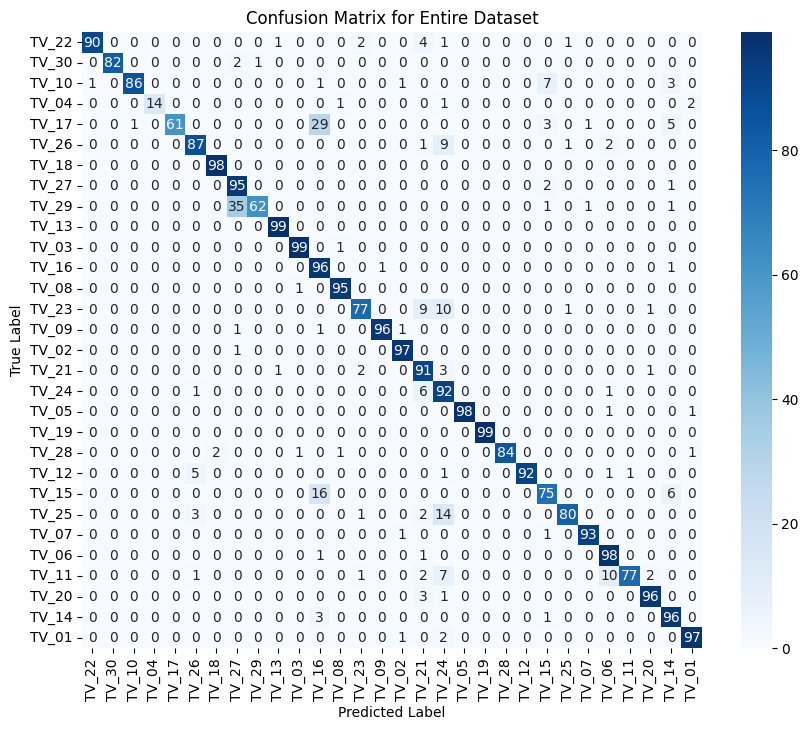

Overall Accuracy on Entire Dataset: 90.88%


In [5]:
import os
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import swin_t, Swin_T_Weights, convnext_tiny, ConvNeXt_Tiny_Weights
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Custom Dataset Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

### Model Choice - Choose One ###

# Option 1: Swin Transformer
model = swin_t(weights=Swin_T_Weights.DEFAULT)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(class_names))  # Adjust final layer

# Option 2: ConvNeXt
# model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
# num_ftrs = model.classifier[2].in_features
# model.classifier[2] = nn.Linear(num_ftrs, len(class_names))  # Adjust final layer

model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adjusted learning rate

# Train the model
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    start_time = time.time()
    
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / dataset_sizes['train']
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / dataset_sizes['val']
    
    elapsed_time = time.time() - start_time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {elapsed_time:.2f}s')

# Combine training and validation images for full evaluation
all_images_combined = train_images + val_images
all_labels_combined = train_labels + val_labels

combined_dataset = CustomDataset(all_images_combined, all_labels_combined, transform=data_transforms)
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate the model on the full dataset
model.eval()
all_preds = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in combined_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_true_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Entire Dataset')
plt.show()

# Calculate overall accuracy
correct = np.sum(np.array(all_preds) == np.array(all_true_labels))
total = len(all_true_labels)
overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Entire Dataset: {overall_accuracy:.2f}%')


Epoch 1/4: 100%|██████████| 54/54 [01:32<00:00,  1.71s/batch, loss=0.767]


Epoch [1/4], Train Loss: 2.0710, Val Loss: 1.1986, Time: 158.02s


Epoch 2/4: 100%|██████████| 54/54 [01:40<00:00,  1.87s/batch, loss=1.81] 


Epoch [2/4], Train Loss: 0.9903, Val Loss: 0.9074, Time: 166.23s


Epoch 3/4: 100%|██████████| 54/54 [01:38<00:00,  1.82s/batch, loss=0.884]


Epoch [3/4], Train Loss: 0.7177, Val Loss: 0.5821, Time: 163.73s


Epoch 4/4: 100%|██████████| 54/54 [01:38<00:00,  1.83s/batch, loss=0.322]


Epoch [4/4], Train Loss: 0.5223, Val Loss: 0.9729, Time: 164.23s
              precision    recall  f1-score   support

       TV_22       0.94      0.78      0.85        40
       TV_30       0.90      0.56      0.69        34
       TV_10       0.86      0.78      0.82        40
       TV_04       1.00      0.38      0.55         8
       TV_17       0.82      0.57      0.68        40
       TV_26       1.00      0.33      0.49        40
       TV_18       0.98      1.00      0.99        40
       TV_27       0.80      0.40      0.53        40
       TV_29       0.75      0.60      0.67        40
       TV_13       0.95      0.97      0.96        40
       TV_03       0.87      1.00      0.93        40
       TV_16       0.69      0.78      0.73        40
       TV_08       1.00      0.90      0.95        39
       TV_23       0.18      0.07      0.11        40
       TV_09       0.96      0.60      0.74        40
       TV_02       0.81      0.85      0.83        40
       TV_21    

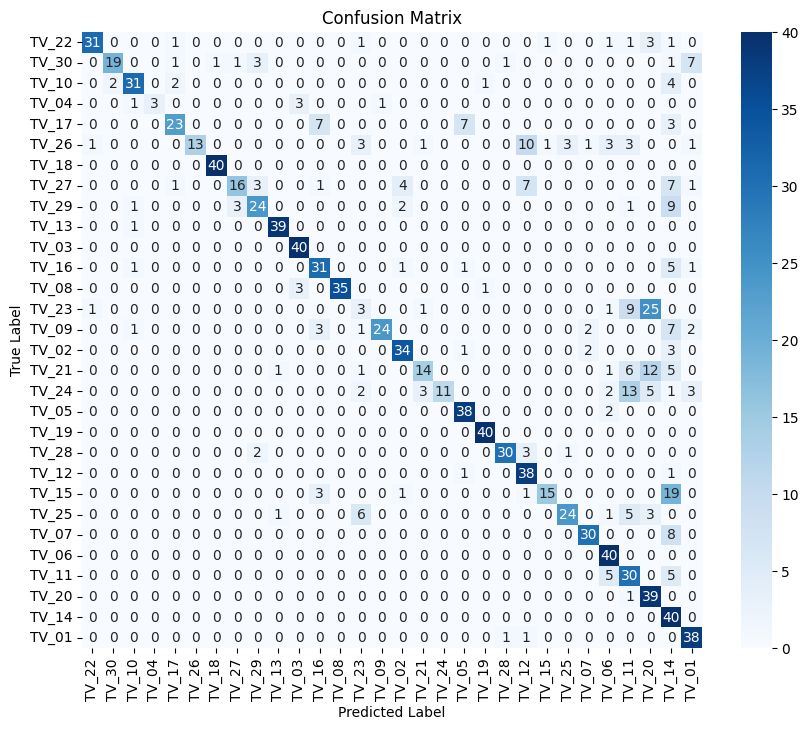

Overall Accuracy on Validation Set: 72.27%


In [31]:
import os
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm  # For progress bar

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.6 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model
model = models.efficientnet_b3(weights='DEFAULT')  # Using EfficientNet-B3
num_ftrs = model.classifier[1].in_features  # Access the Linear layer's in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation loss and time tracking
num_epochs = 4  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    
    # Training phase
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_bar.set_postfix(loss=loss.item())  # Update the progress bar with current loss

    epoch_loss = running_loss / dataset_sizes['train']
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / dataset_sizes['val']
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {elapsed_time:.2f}s')

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm  # For progress bar

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
data_dir = '/kaggle/input/tv-rotnleafonlyfin-zip/TV_rotnleafonlyfin'
all_images = []
all_labels = []
class_names = []

# Load images from each class folder
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        class_names.append(class_folder)
        for img in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img))
            all_labels.append(class_folder)

# Split data into train and validation (80-20)
train_images, val_images, train_labels, val_labels = [], [], [], []

for label in set(all_labels):
    label_indices = [i for i, l in enumerate(all_labels) if l == label]
    random.shuffle(label_indices)
    split_index = int(0.7 * len(label_indices))
    
    for i in label_indices[:split_index]:
        train_images.append(all_images[i])
        train_labels.append(label)
    
    for i in label_indices[split_index:]:
        val_images.append(all_images[i])
        val_labels.append(label)

# Create custom datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_names.index(self.labels[idx])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNet-B3 model
model = models.efficientnet_b3(weights='DEFAULT')  # Using EfficientNet-B3
num_ftrs = model.classifier[1].in_features  # Access the Linear layer's in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer
model = model.to(device)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation loss and time tracking
num_epochs = 4  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    
    # Training phase
    train_bar = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_bar.set_postfix(loss=loss.item())  # Update the progress bar with current loss

    epoch_loss = running_loss / dataset_sizes['train']
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / dataset_sizes['val']
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {elapsed_time:.2f}s')

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy on Validation Set: {overall_accuracy:.2f}%')


Epoch 1/4: 100%|██████████| 63/63 [01:54<00:00,  1.81s/batch, loss=1.05] 


Epoch [1/4], Train Loss: 1.8407, Val Loss: 1.4232, Time: 163.69s


Epoch 2/4: 100%|██████████| 63/63 [01:52<00:00,  1.79s/batch, loss=1.05] 


Epoch [2/4], Train Loss: 0.8686, Val Loss: 0.9879, Time: 161.34s


Epoch 3/4: 100%|██████████| 63/63 [01:53<00:00,  1.80s/batch, loss=0.794]


Epoch [3/4], Train Loss: 0.5824, Val Loss: 0.5571, Time: 161.83s


Epoch 4/4:  95%|█████████▌| 60/63 [01:49<00:03,  1.27s/batch, loss=0.382]